In [1]:
import ufl
from dolfinx import default_scalar_type, fem, la
from dolfinx.fem import functionspace
from dolfinx.fem.petsc import LinearProblem
import numpy as np
import scipy

class LinearSolver:
    def __init__(self, a, L, uh, bcs):
        self.a_compiled = fem.form(a)
        self.L_compiled = fem.form(L)
        self.A = fem.create_matrix(self.a_compiled)
        self.b = fem.Function(uh.function_space)
        self.bcs = bcs
        self._A_scipy = self.A.to_scipy()
        self.uh = uh

    def solve(self):
        self._A_scipy.data[:] = 0

        fem.assemble_matrix(self.A, self.a_compiled, bcs=self.bcs)

        self.b.x.array[:] = 0
        fem.assemble_vector(self.b.x.array, self.L_compiled)
        fem.apply_lifting(self.b.x.array, [self.a_compiled], [self.bcs])
        self.b.x.scatter_reverse(la.InsertMode.add)
        [bc.set(self.b.x.array) for bc in self.bcs]

        A_inv = scipy.sparse.linalg.splu(self._A_scipy)
        self.uh.x.array[:] = A_inv.solve(self.b.x.array)
        return self.uh
    
class Linearsolver_activation:
    def __init__(self, a, loc_loss_form, loc_loss, D_Ih, act, psi, bcs):
        self.adj_compiled = fem.form(a)
        self.L_compiled = fem.form(loc_loss_form)
        self.dL_compiled = fem.form(D_Ih)
        self.Adj = fem.create_matrix(self.adj_compiled)
        self.L = loc_loss
        self.dL = fem.create_matrix(self.dL_compiled)
        self.bcs = bcs
        self._Adj_scipy = self.Adj.to_scipy()
        self._dL_scipy = self.dL.to_scipy()
        self.psi = psi
        self.act = act
    
    def solve(self):
        self._Adj_scipy.data[:] = 0
        self.L.x.array[:] = 0
        self._dL_scipy.data[:] = 0
        fem.assemble_matrix(self.Adj, self.adj_compiled, bcs=self.bcs)
        fem.assemble_matrix(self.dL, self.dL_compiled, bcs=self.bcs)
        fem.assemble_vector(self.L.x.array, fem.form(self.L_compiled))
        
        
        vec = self.act.dx(self.L.x.array) * self._dL_scipy

        fem.apply_lifting(vec, [self.adj_compiled], [self.bcs])
        [bc.set(vec) for bc in self.bcs]

        Adj_inv = scipy.sparse.linalg.splu(self._Adj_scipy)
        self.psi.x.array[:] = Adj_inv.solve(vec)
        return self.psi

    
class loss_act_class:
    def __init__(self, t0):
        self.t0 = t0
    def _z(self, x):
        return x/self.t0
    def __call__(self,x):
        z = self._z(x)
        return np.where(x>self.t0, 1, 1/2*z**4-z**3-1/2*z**2+2*z)
    def dx(self,x):
        z = self._z(x)
        return np.where(x>self.t0, 0, 2*z**3-3*z**2-z+2)/self.t0
    

class FEniCSx_solver:
    def __init__(self, pde_data, loss_form, loss_act):

        #data for FEM-solution-space
        domain,Wh,self.uh,eps,b,c,f,g,bcs = pde_data
        u = ufl.TrialFunction(Wh)
        v = ufl.TestFunction(Wh)

        #FEM space for the SUPG-parameters/weights
        Yh = functionspace(domain, ("DG", 0))
        self.yh = fem.Function(Yh)

        #number of locally owned cells
        self.owned_cells = self.yh.x.index_map.size_local

        #SUPG-forms
        a = eps * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + ufl.dot(b, ufl.grad(u)) * v * ufl.dx
        sh_test = (self.yh * ufl.dot(b, ufl.grad(v))) 
        sh = -eps * ufl.div(ufl.grad(u)) * sh_test * ufl.dx + ufl.dot(b, ufl.grad(u)) * sh_test * ufl.dx
        if c != None:
            sh += c * u * sh_test * ufl.dx
            a +=  c * u * v * ufl.dx

        L = f * v * ufl.dx
        if g is not None:
            L += g * v * ufl.ds
        rh = f * self.yh * ufl.dot(b, ufl.grad(v)) * ufl.dx

        # 1st LinearProblem
        self.prblm = LinearSolver(
            a=a + sh, 
            L=L+rh, 
            bcs=bcs, 
            uh=self.uh
        )
        self.prblm.solve()


        #The adjoint problem
        
        #the adjoint problem needs homgenous boundary conditions.
        dbc_dofs = np.array([], dtype=np.int32)
        for bc in bcs:
            dbc_dofs = np.append(dbc_dofs, bc.dof_indices()[0])
        hom_bcs = [fem.dirichletbc(fem.Constant(domain, default_scalar_type(0.0)), dbc_dofs, Wh)]

        #the trial function needs to be substituted with a coefficient function in order for symbolic differentiation to work.
        self.w = ufl.Coefficient(Wh) 
        self.Rh = ufl.replace(a+sh - L-rh, {u:self.uh})
        self.loc_loss_form = loss_form
        for integral in self.loc_loss_form.integrals():
            integrand = integral.integrand()
            self.loc_loss_form = ufl.replace(self.loc_loss_form, {integrand: integrand * ufl.TestFunction(Yh)})
        local_loss = fem.Function(Yh)
        
        self.loss_act = loss_act

        #forms for the adjoint problem
        Rh_w = ufl.derivative(form=self.Rh, coefficient=self.uh, argument=u)
        self.psi = fem.Function(Wh)
        adjoint_bilin = ufl.replace(ufl.adjoint(Rh_w), {self.uh:v})
        # 2nd LinearProblem
        self.adj_prblm = Linearsolver_activation(
            a=adjoint_bilin, 
            loc_loss_form=self.loc_loss_form,
            loc_loss=local_loss,
            D_Ih=ufl.derivative(form=self.loc_loss_form, coefficient=self.uh), 
            act = self.loss_act,
            bcs=hom_bcs, 
            psi=self.psi
        )
        self.adj_prblm.solve()


        #The gradient problem

        #forms for the gradient computation
        z = ufl.TrialFunction(Yh)
        self.grd_fn = fem.Function(Yh)
        self.Rh_y = ufl.action(ufl.adjoint(ufl.derivative(form=-self.Rh, coefficient=self.yh, argument=z)), self.psi)
        self.grd = fem.Function(Yh)

    def set_weights(self, weights):
        #set weights for locally owned dofs
        self.yh.x.array[:self.owned_cells] = weights[:self.owned_cells]
        self.yh.x.scatter_forward()

        

        self.prblm.solve()

        self.adj_prblm.solve()

    def loss(self):
        return self.loss_act(self.adj_prblm.L.x.array).sum()
    
    def loc_loss(self):
            return self.loss_act(self.adj_prblm.L.x.array)
    
    def grad(self):
        self.grd.x.array[:] = 0
        fem.assemble_vector(self.grd.x.array, fem.form(self.Rh_y))
        return self.grd.x.array
    




# Ex2: Cylinder

In [148]:
#from utils.FEniCSx_solver import FEniCSx_solver
from dolfinx import mesh as msh, fem, default_scalar_type, la
from mpi4py import MPI
import ufl
import numpy as np

import scipy

nx=16
ny=16
comm = MPI.COMM_WORLD
cell_type=msh.CellType.quadrilateral
mesh = msh.create_unit_square(comm=comm, nx=nx, ny=ny, cell_type=cell_type)
test = ufl.TestFunction(fem.functionspace(mesh, ('DG', 0)))
x = ufl.SpatialCoordinate(mesh)
i = ufl.Index()
Wh = fem.functionspace(mesh, ('P', 1))
uh = fem.Function(Wh)
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
boundary_facets = msh.exterior_facet_indices(mesh.topology)
boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
eps = fem.Constant(mesh, default_scalar_type(10**(-3)))
b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(2.0)),fem.Constant(mesh, default_scalar_type(3.0))))
c = fem.Constant(mesh, default_scalar_type(0.0))
expr = 16*x[0]*(1-x[0])*x[1]*(1-x[1])*(1/2+ufl.atan(2*eps**(-1/2)*(0.25**2-(x[0]-0.5)**2-(x[1]-1/2)**2))/ufl.pi)
f = -eps * expr.dx(i).dx(i) + b[i]*expr.dx(i) + c*expr
u_exact = fem.Expression(expr, Wh.element.interpolation_points())
uD = fem.Function(Wh)

uD.interpolate(u_exact)

bcs = [fem.dirichletbc(uD, boundary_dofs)]

pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs



cid_lims = mesh.topology.index_map(2).local_range
marker_ids = np.arange(cid_lims[0], cid_lims[1])

for index in range(cid_lims[0],cid_lims[1]):
    if np.intersect1d(Wh.dofmap.cell_dofs(index), bcs[0].dof_indices()[0]).size > 0:
            marker_ids = marker_ids[marker_ids!=index]

marker = np.ones_like(marker_ids, dtype=np.int32)
cell_tag = msh.meshtags(mesh, mesh.topology.dim, marker_ids, marker)
dx = ufl.Measure("dx", domain=mesh, subdomain_data=cell_tag, subdomain_id=1)

residual = (-eps*ufl.div(ufl.grad(uh)) + ufl.dot(b, ufl.grad(uh)) + c * uh - f)**2 * ufl.dx

b_perp = ufl.conditional(ufl.eq(ufl.inner(b, b),0), b, -ufl.perp(b)/ufl.sqrt(ufl.inner(b,b)))
cross = abs(ufl.dot(b_perp, ufl.grad(uh)))
crosswind_loss = ufl.conditional(ufl.lt(cross, 1), 1/2*(5*cross**2 - 3*cross**3), ufl.sqrt(cross)) * ufl.dx
#loss = (uh-uD)**2 * ufl.dx
loss = residual + crosswind_loss
fs = FEniCSx_solver(pde_data=pde_data, loss_form=loss, loss_act=loss_act_class(0.5))


norm_b = ufl.sqrt(ufl.dot(b,b))
h = ufl.CellDiameter(domain=mesh) 
alpha = norm_b*h/(2*eps)
Xi = (1/ufl.tanh(alpha)-1/alpha)
tau_K = h/(2*norm_b)*Xi
Th = fem.functionspace(mesh, ('DG', 0))
tau = fem.Function(Th)
tau_exp = fem.Expression(tau_K, Th.element.interpolation_points())
tau.interpolate(tau_exp)
fs.set_weights(tau.x.array)


arr = np.array([])



In [5]:
#from utils.FEniCSx_solver import FEniCSx_solver
from dolfinx import mesh as msh, fem, default_scalar_type, la
from mpi4py import MPI
import ufl
import numpy as np

import scipy

nx=32
ny=32
comm = MPI.COMM_WORLD
cell_type=msh.CellType.quadrilateral
mesh = msh.create_unit_square(comm=comm, nx=nx, ny=ny, cell_type=cell_type)

Wh = fem.functionspace(mesh, ('P', 1))
uh = fem.Function(Wh)
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
boundary_facets = msh.exterior_facet_indices(mesh.topology)
boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
eps = fem.Constant(mesh, default_scalar_type(1e-8))
b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
c = fem.Constant(mesh, default_scalar_type(0.0))
f = fem.Constant(mesh, default_scalar_type(1.0))
bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs



cid_lims = mesh.topology.index_map(2).local_range
marker_ids = np.arange(cid_lims[0], cid_lims[1])

for index in range(cid_lims[0],cid_lims[1]):
    if np.intersect1d(Wh.dofmap.cell_dofs(index), bcs[0].dof_indices()[0]).size > 0:
            marker_ids = marker_ids[marker_ids!=index]

marker = np.ones_like(marker_ids, dtype=np.int32)
cell_tag = msh.meshtags(mesh, mesh.topology.dim, marker_ids, marker)
dx = ufl.Measure("dx", domain=mesh, subdomain_data=cell_tag, subdomain_id=1)

x = ufl.SpatialCoordinate(mesh)
ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - ((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps))- ufl.exp(-1/eps))/(1-ufl.exp(-1/eps)))

exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

u_ex = fem.Function(Wh)
u_ex.interpolate(exp)

n=ufl.FacetNormal(mesh)
residual = (-eps*ufl.div(ufl.grad(uh)) + ufl.dot(b, ufl.grad(uh)) + c * uh - f)**2 * ufl.dx

b_perp = ufl.as_vector((fem.Constant(mesh, default_scalar_type(0.0)),fem.Constant(mesh, default_scalar_type(-1.0))))
cross = abs(ufl.dot(b_perp, ufl.grad(uh)))
crosswind_loss = ufl.conditional(ufl.lt(cross, 1), 1/2*(5*cross**2 - 3*cross**3), ufl.sqrt(cross)) * ufl.dx
#loss = (uh-u_ex)**2 * ufl.dx
loss = residual + crosswind_loss
fs = FEniCSx_solver(pde_data=pde_data, loss_form=loss, loss_act=loss_act_class(1/100))


norm_b = ufl.sqrt(ufl.dot(b,b))
h = ufl.CellDiameter(domain=mesh) 
alpha = norm_b*h/(2*eps)
Xi = (1/ufl.tanh(alpha)-1/alpha)
tau_K = h/(2*norm_b)*Xi
Th = fem.functionspace(mesh, ('DG', 0))
tau = fem.Function(Th)
tau_exp = fem.Expression(tau_K, Th.element.interpolation_points())
tau.interpolate(tau_exp)
fs.set_weights(tau.x.array)


arr = np.array([])

upper = 100*fs.yh.x.array

In [ ]:
from scipy.optimize import minimize
from dolfinx import io

upper = 100*fs.yh.x.array
def callback(intermediate_result):
    fval = intermediate_result.fun
    print(f"J: {fval}")


def eval(weights):
    fs.set_weights(weights=weights)
    return fs.loss()

def eval_grad(weights):
    return fs.grad()

bounds = scipy.optimize.Bounds(lb=np.zeros_like(fs.yh.x.array), ub=upper)
minimize(
    fun=eval,
    x0=fs.yh.x.array,
    jac=eval_grad,
    method='L-BFGS-B',
    tol=1e-9,
    options={"disp": False},
    callback=callback,
    bounds=bounds
)

J: 16.2352993761011
J: 15.182128159679415
J: 14.852087963476606
J: 14.751832164587912
J: 14.448475836370005
J: 14.340111957038076
J: 14.294810038669329
J: 14.278863898651505
J: 14.263163275524978
J: 14.251305232962387
J: 14.245260873337827
J: 14.241553172223195
J: 14.233422350545315
J: 14.229210718531311
J: 14.224070415028766
J: 14.220167869572377
J: 14.213378647747929
J: 14.20884155608487
J: 14.20662963384262
J: 14.204179572988668
J: 14.202174263511253
J: 14.199944042288154
J: 14.19780914772036
J: 14.196151459744891
J: 14.19313502417817
J: 14.191797629872841
J: 14.190676077525698
J: 14.188764985126202
J: 14.187672087790954
J: 14.186198845637279
J: 14.18479646319597
J: 14.18379127843514
J: 14.182888929880868
J: 14.181884514362517
J: 14.181232268037995
J: 14.180350854419315
J: 14.179745485975763
J: 14.17916696201035
J: 14.178488359888537
J: 14.177955731674508
J: 14.177351349828484
J: 14.176980230218335
J: 14.17658973019231
J: 14.175990208981556
J: 14.175494329074475
J: 14.17506942270117

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.166221946759233
        x: [ 2.698e-02  1.482e-02 ...  4.370e-01  6.434e-01]
      nit: 1411
      jac: [ 6.774e-05 -3.581e-05 ... -7.547e-06 -8.388e-06]
     nfev: 1473
     njev: 1473
 hess_inv: <256x256 LbfgsInvHessProduct with dtype=float64>

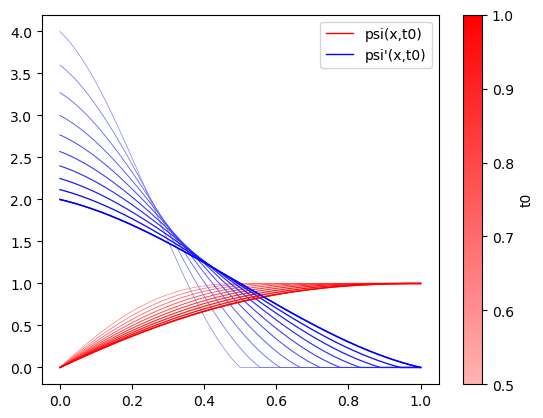

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

arr = np.linspace(0, 1, 1000)

# ---- t0 range ----
t0_min, t0_max = 0.5, 1.0
norm = mpl.colors.Normalize(vmin=t0_min, vmax=t0_max)

# ---- colormap matching (1, 1-t0, 1-t0) ----
colors = [(1, 1 - t, 1-t) for t in np.linspace(0.3, t0_max, 256)]
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots()

for t0 in np.linspace(0.5, 1, 10):
    psi = loss_act_class(t0)

    ax.plot(
        arr,
        psi.dx(arr),
        color=(1 - t0, 1 - t0, 1),
        linewidth=t0
    )

    ax.plot(
        arr,
        psi(arr),
        linestyle='-',
        linewidth=t0,
        color=(1, 1 - t0, 1 - t0)
    )

# ---- t0 = 1 case ----
t0 = 1.0
psi = loss_act_class(t0)


ax.plot(arr, psi(arr),
        color=(1, 0, 0),
        linewidth=t0,
        label="psi(x,t0)")

ax.plot(arr, psi.dx(arr),
        color=(0, 0, 1),
        linewidth=t0,
        label="psi'(x,t0)")

ax.legend()

# ---- colorbar ----
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # compatibility

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("t0")

plt.show()


In [2]:
from SPDE_problems import curved_waves as fs
from utils.plotter import fem_plotter_grid
import pyvista as pv
pv.global_theme.cmap = 'coolwarm'

fs = fs()


p = pv.Plotter()

grid = fem_plotter_grid(fs.uh.function_space)
grid.add_data(fs.uh)
p.add_mesh(
    grid.grid.warp_by_scalar(), 
    show_edges=True
)


p.show()

ld: warning: duplicate -rpath '/Users/vincentdallmer/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/Users/vincentdallmer/anaconda3/envs/fenicsx-env/lib' ignored


Widget(value='<iframe src="http://localhost:52860/index.html?ui=P_0x306149f90_1&reconnect=auto" class="pyvista…